# Correlation and Blocking

One important part of the sampling is to estimate the correlation between the different sampling points.
To this end let's import the following modules

In [1]:
from qmctorch.scf import Molecule
from qmctorch.wavefunction import SlaterJastrow
from qmctorch.sampler import Metropolis
from qmctorch.solver import Solver
from qmctorch.utils import set_torch_double_precision
from qmctorch.utils.plot_data import blocking, plot_blocking_energy
from qmctorch.utils.plot_data  import plot_correlation_coefficient, plot_integrated_autocorrelation_time

INFO:QMCTorch|  ____    __  ______________             _
INFO:QMCTorch| / __ \  /  |/  / ___/_  __/__  ________/ /  
INFO:QMCTorch|/ /_/ / / /|_/ / /__  / / / _ \/ __/ __/ _ \ 
INFO:QMCTorch|\___\_\/_/  /_/\___/ /_/  \___/_/  \__/_//_/ 
INFO:QMCTorch|
INFO:QMCTorch|0.4.0


## Setting up the system

Let's create a simple H2 molecule and a Slater Jastrow wave fuction to demonstrate the correlation properties of the sampling

In [2]:
set_torch_double_precision()
mol = Molecule(atom = 'H 0. 0. 0; H 0. 0. 1.', calculator='pyscf', unit='bohr', redo_scf=True)

INFO:QMCTorch|
INFO:QMCTorch| SCF Calculation
INFO:QMCTorch|  Removing H2_pyscf_dzp.hdf5 and redo SCF calculations
INFO:QMCTorch|  Running scf  calculation
converged SCF energy = -1.07280585930373
INFO:QMCTorch|  Molecule name       : H2
INFO:QMCTorch|  Number of electrons : 2
INFO:QMCTorch|  SCF calculator      : pyscf
INFO:QMCTorch|  Basis set           : dzp
INFO:QMCTorch|  SCF                 : HF
INFO:QMCTorch|  Number of AOs       : 10
INFO:QMCTorch|  Number of MOs       : 10
INFO:QMCTorch|  SCF Energy          : -1.073 Hartree


In [3]:
wf = SlaterJastrow(mol, configs='ground_state')

INFO:QMCTorch|
INFO:QMCTorch| Wave Function
INFO:QMCTorch|  Backflow            : False
INFO:QMCTorch|  Jastrow factor      : True
INFO:QMCTorch|  Jastrow kernel      : ee -> PadeJastrowKernel
INFO:QMCTorch|  Highest MO included : 10
INFO:QMCTorch|  Configurations      : ground_state
INFO:QMCTorch|  Number of confs     : 1
INFO:QMCTorch|  Kinetic energy      : jacobi
INFO:QMCTorch|  Number var  param   : 122
INFO:QMCTorch|  Cuda support        : False


We can also define a simple Metropolis sampler:

In [4]:
sampler = Metropolis(nwalkers=100, nstep=500, step_size=0.25,
                    nelec=wf.nelec, ndim=wf.ndim,
                    init=mol.domain('normal'),
                    ntherm=0, ndecor=1,
                    move={'type': 'all-elec', 'proba': 'normal'})

INFO:QMCTorch|
INFO:QMCTorch| Monte-Carlo Sampler
INFO:QMCTorch|  Number of walkers   : 100
INFO:QMCTorch|  Number of steps     : 500
INFO:QMCTorch|  Step size           : 0.25
INFO:QMCTorch|  Thermalization steps: 0
INFO:QMCTorch|  Decorelation steps  : 1
INFO:QMCTorch|  Walkers init pos    : normal
INFO:QMCTorch|  Move type           : all-elec
INFO:QMCTorch|  Move proba          : normal


note that by setting `nthemr=0` and `ndecor=1`, we record all the walker positions along the trajectory. 

We can then define the solver:

In [5]:
solver = Solver(wf=wf, sampler=sampler)

INFO:QMCTorch|
INFO:QMCTorch| QMC Solver 
INFO:QMCTorch|  WaveFunction        : SlaterJastrow
INFO:QMCTorch|  Sampler             : Metropolis


## Correlation coefficient

The simplest way to estimate the decorelation time is to compute the autocorrelation coefficient of the local energy. To this end we must first record the sampling trajectory, i.e. the values of the local energies along the path of the walkers:

In [6]:
pos = solver.sampler(solver.wf.pdf)
obs = solver.sampling_traj(pos)

INFO:QMCTorch|  Sampling: 100%|██████████| 500/500 [00:06<00:00, 79.81it/s] 


INFO:QMCTorch|   Acceptance rate     : 62.03 %
INFO:QMCTorch|   Timing statistics   : 79.79 steps/sec.
INFO:QMCTorch|   Total Time          : 6.27 sec.
INFO:QMCTorch|
INFO:QMCTorch|  Sampling trajectory


INFO:QMCTorch|  Energy  : 100%|██████████| 500/500 [00:20<00:00, 24.41it/s]


We can then plot the correlation coefficient with:

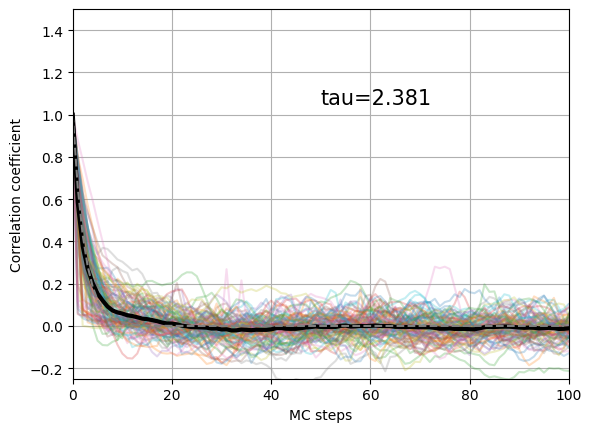

In [7]:
rho, tau = plot_correlation_coefficient(obs.local_energy)

On this picture is represented the autocorrelation coefficient of the local energy of all the walkers (transparent colorful line)
and the average of the autocorrelation coefficient (thick black line). This mean value is fitted with an exponential decay
to obtain the autocorrelation time that is here equal to 1.79 MCs.

## Integrated autocorrelation time

Another way to estimate the correlation time is to compute the integrated autocorrelation time. This can be done with

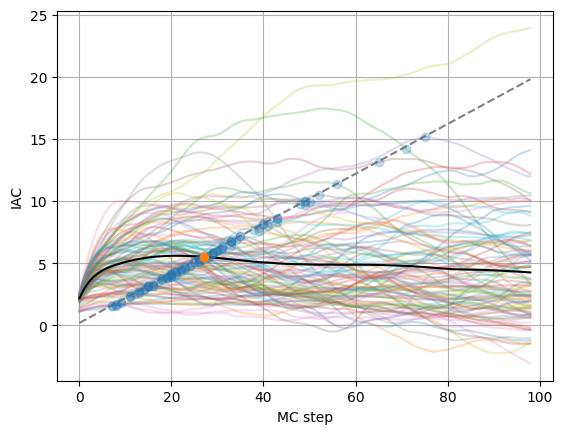

27

In [8]:
plot_integrated_autocorrelation_time(obs.local_energy)

A conservative estimate of the correlation time can be obtain when the iac cross the dashed line, leading here to a value of about 20 steps.

## Energy blocking

It is also common practice to use blocking of the local energy values to reduce the variance. This can easily be done with

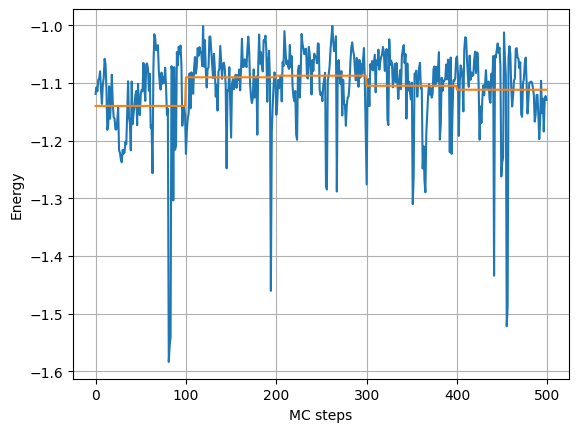

In [9]:
eb = plot_blocking_energy(obs.local_energy, block_size=100, walkers='mean')

That shows the raw and blocked values of the mean local energy values.